**линейный классификатор** 

Евгений Борисов  <esborisov@sevsu.ru>

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=2)
%precision 3

# генерируем данные

In [3]:
# from sklearn.datasets import make_moons
# X,target = make_moons(n_samples=n_samples, noise=.09)

In [4]:
from sklearn.datasets import make_blobs
X,target = make_blobs( n_samples=1024, centers=2,  cluster_std=[1.5, 1.8,] )

(1024, 2)

(1024, 1)

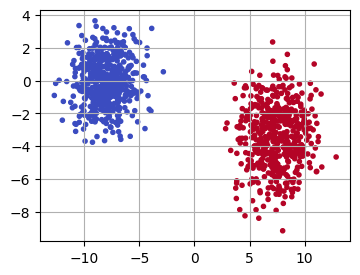

In [5]:
target = target.reshape(-1,1)
display(X.shape, target.shape)

fig,ax = plt.subplots( figsize=(4,3),)
ax.scatter(x=X[:,0],y=X[:,1],c=target, marker='.', cmap='coolwarm')
ax.grid()

In [6]:
# нормируем данные

# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

from sklearn.preprocessing   import StandardScaler
X = StandardScaler().fit(X).transform(X)

display( X.min(),np.mean(X),np.median(X),X.max() )

-3.1237117477316554

9.69276742202041e-17

0.06753328630896932

2.270795107125575

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, target_train, target_test = train_test_split(X,target,test_size=.5)
display( X_train.shape, X_test.shape, )

assert len(target_train) == len(X_train)
assert len(target_test) == len(X_test)

del X,target

(512, 2)

(512, 2)

# модель

$$a(x,w) = \sum\limits_{i=1} x_i \cdot w_i + w_0$$

In [8]:
class LinearClassifier:
    
    def __init__( self, weight=np.array([]), score_threshold=.5 ):
        self._weight = weight
        self._score_threshold = score_threshold
    
    def score(self,x):
        assert len(x)>0
        assert x.shape[1]==len(self._weight)
        return x.dot(self._weight)
    
    def predict(self,x): 
        return (self.score(x)>self._score_threshold).astype(np.uint8)
    
    @property
    def weight(self): return self._weight

    @weight.setter
    def weight(self,value): self._weight = value
        
    def weight_init(self,n): 
        self._weight = rng.normal(size=(n,1),scale=1e-3)
        return self
        
    @property
    def score_threshold(self): return self._score_threshold

    @score_threshold.setter
    def score_threshold(self,value): self._score_threshold = value
    
    def score_partial(self,x): # частные производные модели по её параметрам
        return x

In [9]:
# LinearClassifier( weight=rng.rand(X_train.shape[1],1) ).score(X_train)

# обучаем модель

функция потери средняя квадратичная ошибка
$$L=MSQE(y,o)=\frac{1}{m}\sum\limits_{i=0}^m(o_i-y_i)^2$$

частные производные функции потери по параметрам модели (градиент)

$$ \frac{\partial L }{\partial w} = 2 \cdot( o - y ) \cdot \frac{\partial o }{\partial w}  $$

In [10]:
class MSQELoss:

    @staticmethod
    def score(target,predicted): 
        d = predicted - target
        return d.T.dot(d).flatten()[0]/len(d)
    
    @staticmethod
    def partial( target, predicted, model_partial, ): # градиент функции потери,
        g = model_partial.T.dot( predicted - target ) # градиент msqe
        g /= np.abs(g).max() # нормируем градиент
        return g #.flatten()    
        

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
from tqdm.auto import tqdm

In [13]:
class TrainGD:
    
    def __init__(self,model,loss):
        self._model = model
        self._loss = loss   
        self._lr = .1     
       
    
    def fit( self, X, target, lr=1e-2, n_epoch=512, acc_min=.999, ): 
        # n_epoch - максимальное число циклов обучения
        # acc_min - порог минимально допустимой погрешности модели
        self._lr = lr   # скорость обучения

        n_param = X.shape[1] # размер вектора признаков

        # инициализация параметров модели
        self._model.weight_init(n_param)

        # начальное значение ф-ции потери
        loss_history = [ self._loss.score(target,self._model.score(X)) ]
        acc_history = [ accuracy_score(target,self._model.predict(X)) ]

        for i in tqdm(range(n_epoch)): # цикл обучения
            self._fit_epoch(X,target) # корректируем веса модели
            loss_history.append(  self._loss.score(target,self._model.score(X)) ) # считаем значение ф-ции потери
            acc_history.append( accuracy_score(target,self._model.predict(X)) )

            if acc_history[-1] > acc_min: # проверяем достижение минимального порога погрешности модели
                acc = acc_history[-1]
                print(f'step {i+1}/{n_epoch}: acc {acc:.3f}, threshold {acc_min:.3f} reached\n')  
                break
                
        return (acc_history,loss_history), self._model
    
    @property
    def model(self): return self._model
    
    def _fit_epoch(self,X,target):
        # градиент функции потери, изменение весов
        g = self._loss.partial(target,self._model.score(X),self._model.score_partial(X) ) 
        self._weight_adjust(g) # корректируем параметры    
        return self
        
    def _weight_adjust(self,g):
        self._model.weight = self._model.weight - self._lr*g   # корректируем параметры
        return self
        

In [14]:
from sklearn.preprocessing import PolynomialFeatures

# собираем полином, добавляем столбец из единиц (свободный член)
poly = PolynomialFeatures( degree=1, interaction_only=False, include_bias=True,).fit(X_train)
# poly.transform(X_train)

In [15]:
(acc_history,loss_history), model = TrainGD(
        model=LinearClassifier(),
        loss=MSQELoss()
    ).fit( 
        poly.transform(X_train),
        target_train,
    )

  0%|          | 0/512 [00:00<?, ?it/s]

step 43/512: acc 1.000, threshold 0.999 reached



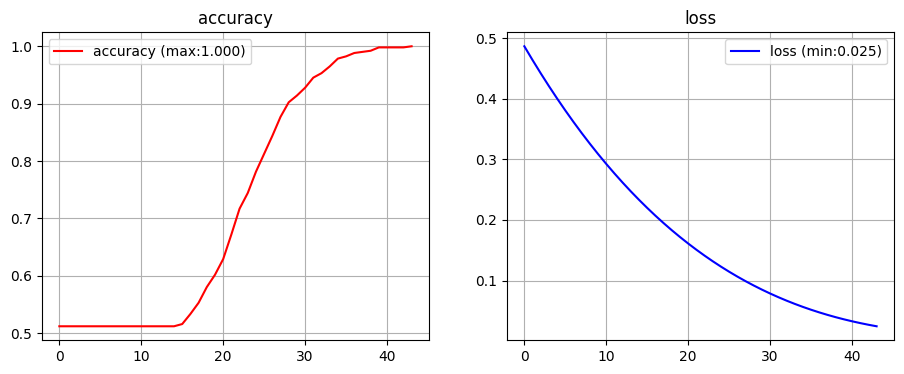

In [16]:
# история изменения значений погрешности модели
fig,ax = plt.subplots(ncols=2,figsize=(11,4))
ax[0].plot(acc_history,label=f'accuracy (max:{max(acc_history):.3f})',c='r' )
ax[0].grid()
ax[0].set_title('accuracy')
ax[0].legend()
ax[1].plot(loss_history,label=f'loss (min:{min(loss_history):.3f})',c='b' )
ax[1].grid()
ax[1].set_title('loss')
ax[1].legend()

In [17]:
# оптимальный порого скора 

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve( target_train, model.score(poly.transform(X_train)) )

#  максимальное количество True Positive при минимальном количестве False Positive
optimal_threshold = thresholds[ np.argmax( np.abs(tpr-fpr) )  ]
display(optimal_threshold)

0.5087094425209464

In [18]:
model.score_threshold = optimal_threshold

## тестируем модель

In [19]:
from sklearn.metrics import classification_report

predicted =  model.predict(poly.transform(X_test))
print(classification_report( target_test, predicted) )

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       262

    accuracy                           1.00       512
   macro avg       1.00      1.00      1.00       512
weighted avg       1.00      1.00      1.00       512



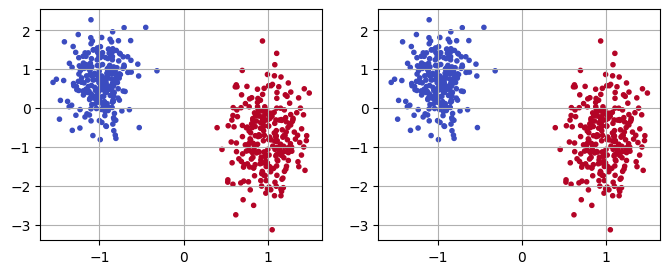

In [20]:
fig,ax = plt.subplots(1,2, figsize=(8,3),)
ax[0].scatter(x=X_test[:,0],y=X_test[:,1],c=target_test, marker='.', cmap='coolwarm')
ax[0].grid()
ax[1].scatter(x=X_test[:,0],y=X_test[:,1],c=predicted, marker='.', cmap='coolwarm')
ax[1].grid()

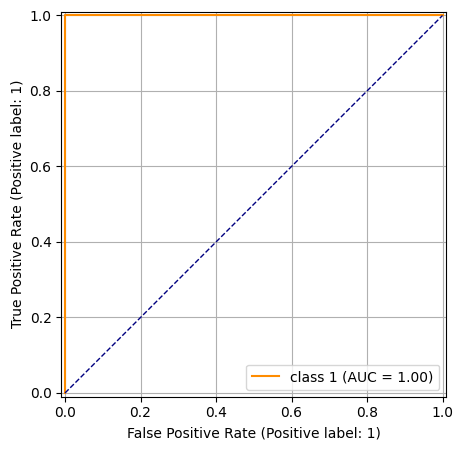

In [21]:
from sklearn.metrics import RocCurveDisplay

score = model.score(poly.transform(X_test))

fig,ax = plt.subplots( figsize=(6,5),)
RocCurveDisplay.from_predictions( target_test, score, name='class 1', color='darkorange', ax=ax )
ax.plot([0,1],[0,1], color='navy', lw=1, linestyle='--')
ax.grid()

## карта скоров

In [22]:
# строим сетку 

n = 50 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) # узлы сетки
display( ( xx.shape, yy.shape ) )

xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 
display( xy.shape )

# plt.figure(figsize=(7,7))
# plt.scatter( x=xy[:,0], y=xy[:,1], s=1 )
# plt.show()

((50, 50), (50, 50))

(2500, 2)

In [23]:
from sklearn.preprocessing import MinMaxScaler

# вычисляем скор для каждого узла сетки
score_xy = model.score(poly.transform(xy))
score_xy = MinMaxScaler(feature_range=(0.,1.)).fit_transform( score_xy )
score_xy = score_xy.reshape(n,n) 

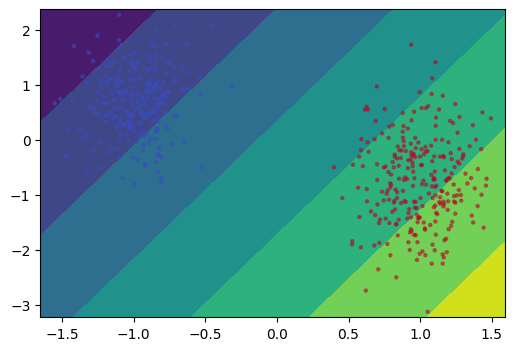

In [24]:
from matplotlib.colors import ListedColormap
fig,ax = plt.subplots(figsize=(6,4),sharey=True)
ax.contourf(xx, yy, score_xy )
ax.scatter( x=X_test[:,0], y=X_test[:,1], c=target_test, alpha=.5, s=5,  cmap='coolwarm' )
#ax[0].grid()

In [25]:
# вычисляем скор для каждого узла сетки
predict_xy = model.predict(poly.transform(xy)).reshape(n,n) 

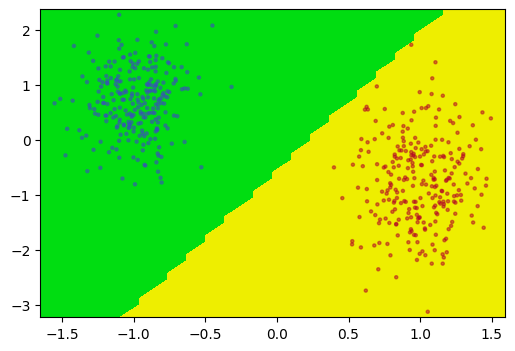

In [26]:
fig,ax = plt.subplots(figsize=(6,4),sharey=True)
ax.contourf(xx, yy, predict_xy, cmap=ListedColormap(['#0d1','#ee0']) )
ax.scatter( x=X_test[:,0], y=X_test[:,1], c=target_test, alpha=.5, s=5,  cmap='coolwarm' )